In [2]:
import os
import random
from glob import glob

import pandas as pd
import plotnine as p9

import torchaudio

CONVERSATIONS = "data/conversations"

p9.theme_set(
    p9.theme_minimal() + 
    p9.theme(
        figure_size=(12, 6),
        panel_background = p9.element_rect(fill='white'),
        plot_background = p9.element_rect(fill='white'),
        plot_title=p9.element_text(color='black', size=16, weight='bold'),
        axis_line=p9.element_line(color='black'),
        axis_title=p9.element_text(color='black', size=14),
        axis_text=p9.element_text(color='black', size=12),
        axis_ticks=p9.element_line(color='black')
    )
)

In [3]:
conversations = glob(os.path.join(CONVERSATIONS, "*"))
audio_files = [glob(os.path.join(c, "processed", "*.mp3"))[0] for c in conversations]

Let's begin with visualizing the waveform for a random conversation.

Profession grade audio use a default sampling rate of 48KHz (like here). We might have to use a smaller sampling rate, just so that it's easier to plot the waveform.

In [4]:
# sample a random conversation
# why 42? because 42 is the answer to life, the universe and everything (according to The Hitchhiker's Guide to the Galaxy)
random.seed(42)
random_conversation = random.sample(audio_files, 1)[0]
print("Random conversation:", random_conversation)

# load the audio file
yt, sr = torchaudio.load(random_conversation)

print("Tensor shape:", yt.shape)  # This will show [channels, samples]
print("Number of channels:", yt.shape[0])
print("Number of samples:", yt.shape[1])
print("Sample rate:", sr)
print("Duration (minutes):", yt.shape[1] / sr / 60)

# Convert to mono if stereo
if yt.shape[0] > 1:
    yt = yt.mean(dim=0)  # Average channels to get mono
else:
    yt = yt.squeeze(0)  # Remove channel dimension for mono

Random conversation: data/conversations/67836c1d-1334-41a0-a33a-4f788e8b6fb3/processed/67836c1d-1334-41a0-a33a-4f788e8b6fb3.mp3


/home/ssubrahmanya/.local/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.


Tensor shape: torch.Size([2, 83189423])
Number of channels: 2
Number of samples: 83189423
Sample rate: 48000
Duration (minutes): 28.885216319444446


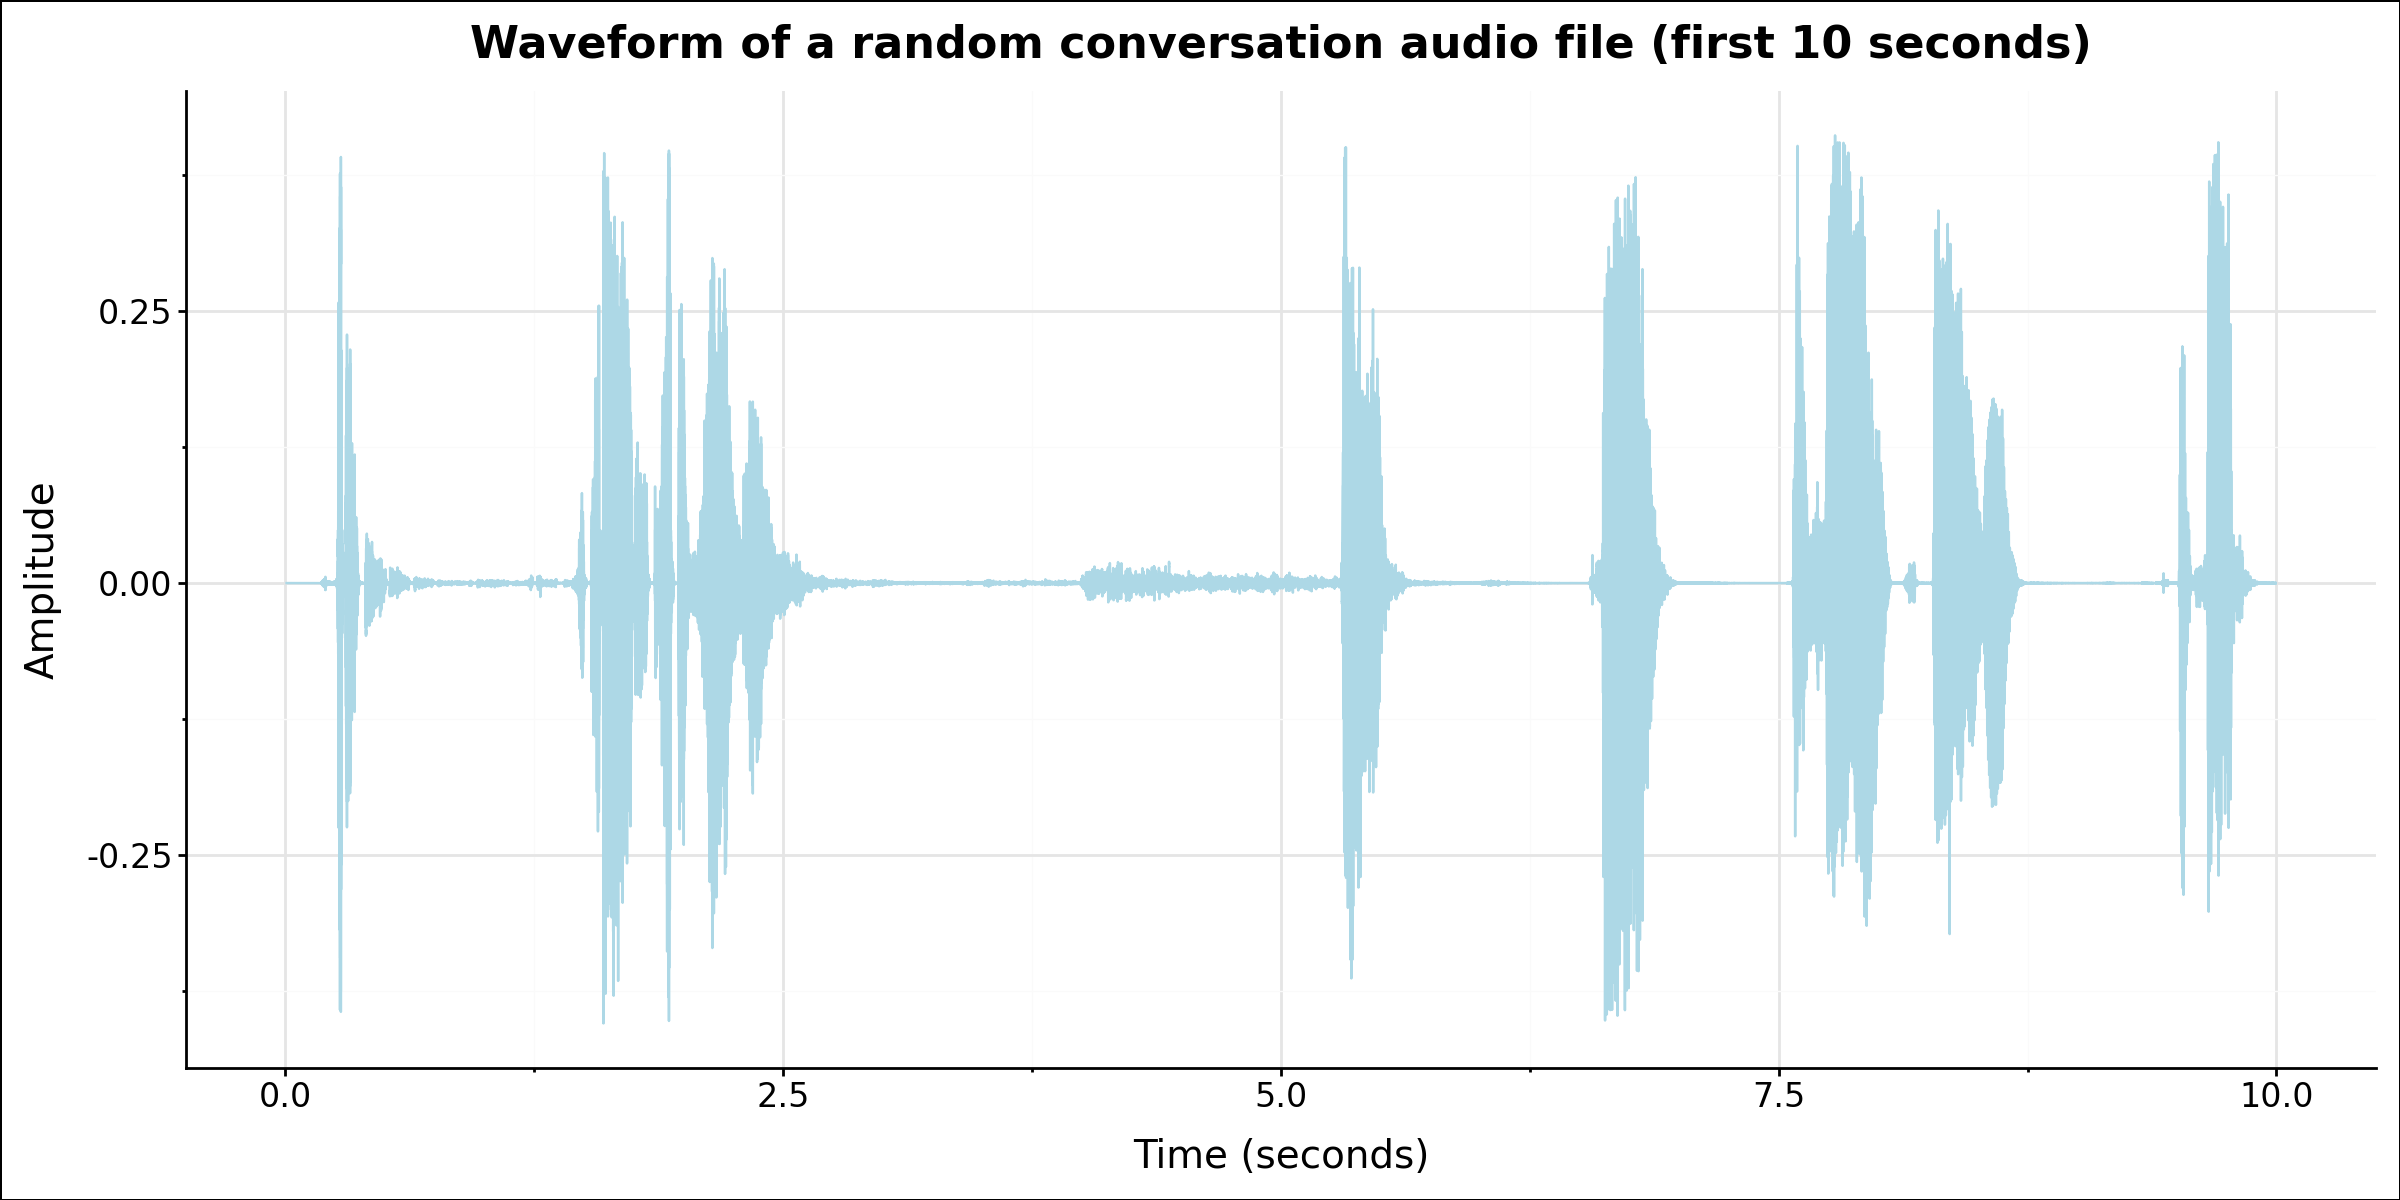

In [5]:
start = 0
end = sr * 10  # first 10 seconds

point = pd.DataFrame({
    "Sample Index": range(start, end),
    "Time": [i / sr for i in range(start, end)],
    "Amplitude": yt[start:end]
})

(
    p9.ggplot(point, p9.aes(x="Time", y="Amplitude"))
    + p9.geom_line(color="lightblue", size=0.5)
    + p9.labs(
        title="Waveform of a random conversation audio file (first 10 seconds)", 
        x="Time (seconds)", 
        y="Amplitude")
)

Data preprocessing methods used by [Di Stasi et al. (2023)](https://psycnet.apa.org/record/2024-16512-001).

1. Each negotiation session was recorded as a single file (similar to CANDOR). The authors used [Trint](https://trint.com) software for ASR and generate transcripts to their utterrance, and NLP to annotate the speaker turns -- thus there's a step transcript generation here.

2. In the other method, they recorded separate audio files for both speakers and used Trint for automatic VAD on both files.

<br/>

| Metrics       | Speech processing steps |
|---------------|-------------------------|
| Speaking time |                   |
| Turn length   | Data 2                  |
| Pauses        | Data 3                  |
| Speech rate   | Data 4                  |
| Interruptions | Data 5                  |
| Backchannels  | Data 6                  |
| Response time | Data 7                  |

phonemes (?)

In [15]:
from convodynamics.preprocess import diarize_audio

segments, total_duration = diarize_audio(random_conversation)

/data/candor/convodynamics/preprocess.py:18: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
/home/ssubrahmanya/.local/lib/python3.9/site-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
/home/ssubrahmanya/.local/lib/python3.9/site-packages/torchaudio/_backend/soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been de

In [26]:
segments.groupby("speaker")["duration"].median()

speaker
SPEAKER_00    1.248750
SPEAKER_01    0.379687
SPEAKER_02    1.248750
Name: duration, dtype: float64